# Term Deposit Marketing
---
## Summary
**Background:**

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

**Data Description:**

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

**Goal(s):**

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

**Success Metric(s):**

Hit 81% or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

**Bonus(es):**

We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

What makes the customers buy? Tell us which feature we should be focusing more on.

# Exploratory Data Analysis

## Import Libraries

In [51]:
# Standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# From previous
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import cross_val_score

# New
from sklearn.impute import SimpleImputer
from sklearn.utils import resample, class_weight

# Warnings
import warnings

# Suppress deprecation warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=UserWarning)

In [53]:
def runModels(models, model_names, x_train, x_test, y_train, y_test):
    # Create subplots for confusion matrices and ROC curves
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    # Iterate over models
    for i, model in enumerate(models):
        # Train the model
        model.fit(x_train, y_train)
        
        # Make predictions
        y_pred = model.predict(x_test)
        y_pred_prob = model.predict_proba(x_test)[:, 1]
        
        # Calculate scores
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Compute confusion matrix
        #cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix - NEW
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0, i])
        axes[0, i].set_title(f'{model_names[i]} Confusion Matrix')
        
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        axes[1, i].plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
        axes[1, i].plot([0, 1], [0, 1], 'k--')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('False Positive Rate')
        axes[1, i].set_ylabel('True Positive Rate')
        axes[1, i].set_title(f'{model_names[i]} ROC Curve')
        axes[1, i].legend(loc='lower right')
        axes[1, i].text(0.5, -0.25, f'Accuracy: {accuracy:.2f}', transform=axes[1, i].transAxes, ha='right')
        axes[1, i].text(0.5, -0.30, f'Precision: {precision:.2f}', transform=axes[1, i].transAxes, ha='right')
        axes[1, i].text(0.5, -0.35, f'Recall: {recall:.2f}', transform=axes[1, i].transAxes, ha='right')
        axes[1, i].text(0.5, -0.40, f'F1: {f1:.2f}', transform=axes[1, i].transAxes, ha='right')

    # Adjust spacing and layout
    plt.tight_layout()
    plt.show()

## Import Data

In [2]:
# Load the data from a CSV file
dataset = pd.read_csv('term-deposit-marketing-2020.csv')

# Extract the input features (x) and output (y) from the dataset
x = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (40000, 13)
y shape: (40000,)


## Basic Data Shapes

Dataset shape: (40000, 14)
Columns: Index(['y', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign'],
      dtype='object')


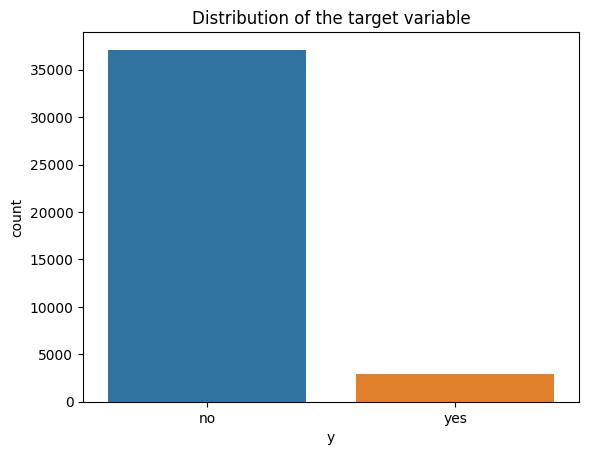

                age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000


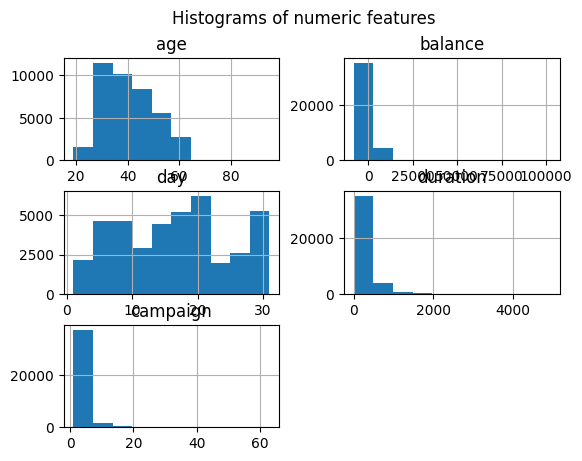

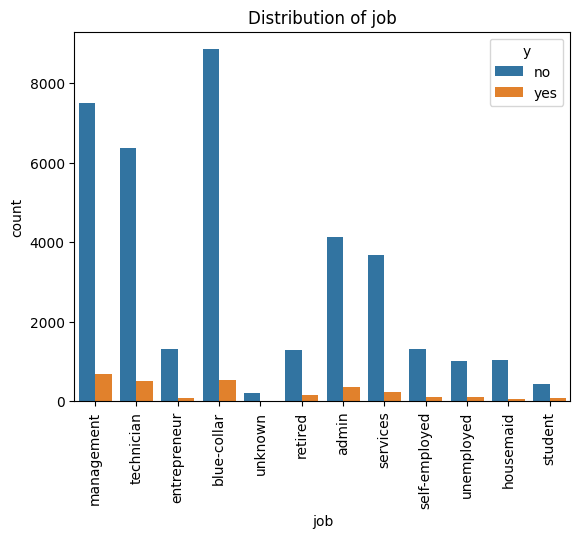

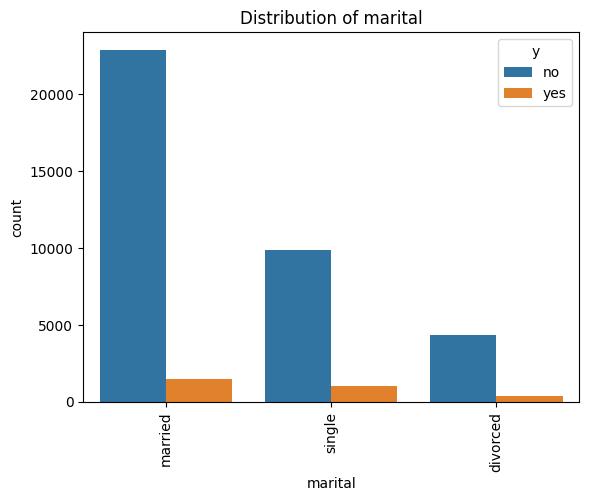

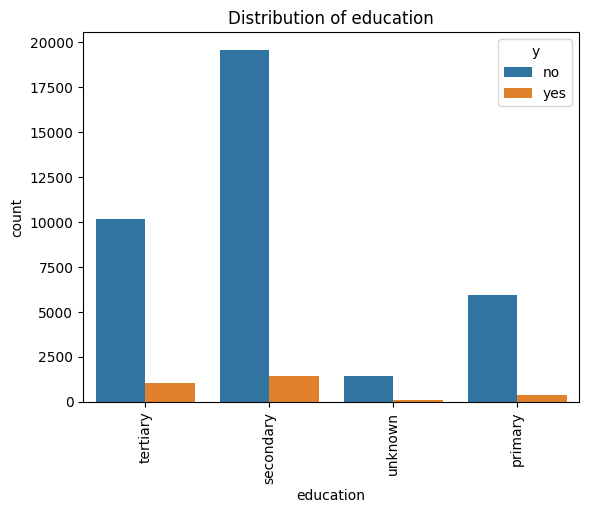

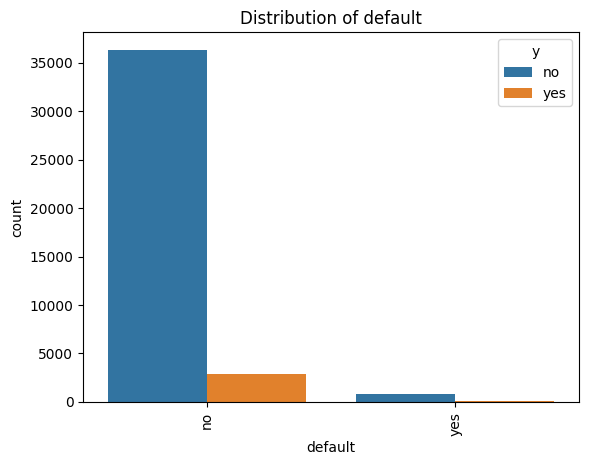

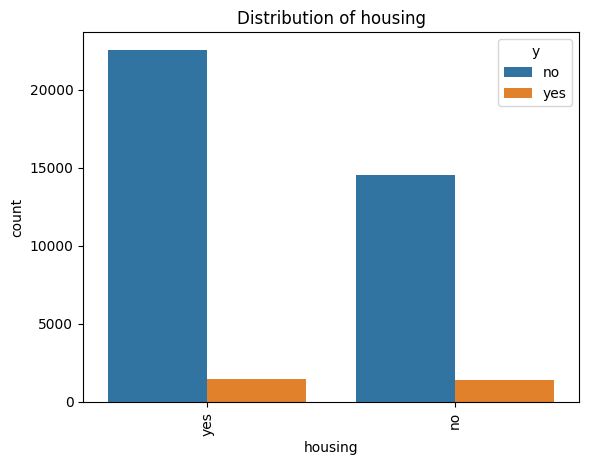

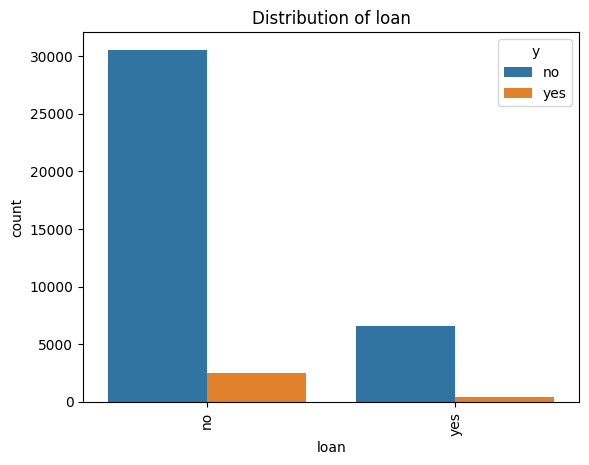

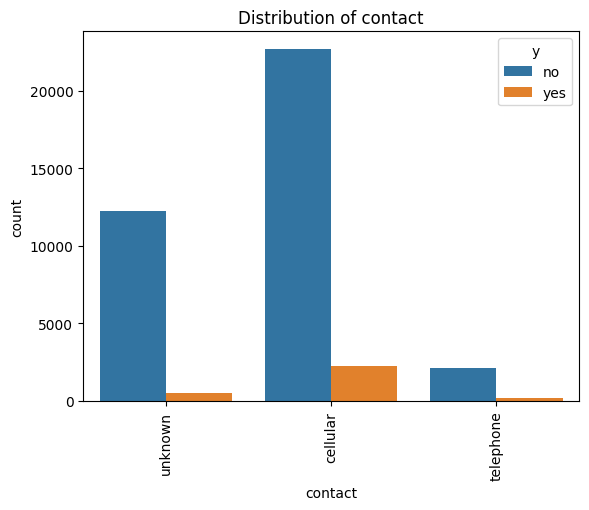

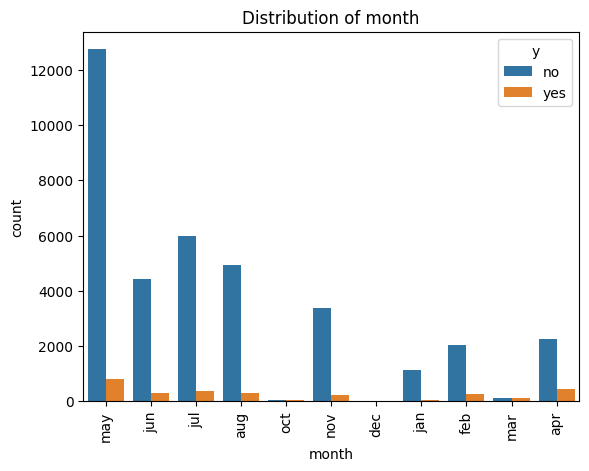

In [3]:
# Display basic information about the dataset
print("Dataset shape:", dataset.shape)
print("Columns:", dataset.columns)

# Get the column names of the input features
feature_columns = dataset.columns[1:]

# Check the distribution of the target variable
sns.countplot(x='y', data=dataset)
plt.title("Distribution of the target variable")
plt.show()

# Explore the numeric features
numeric_features = dataset[feature_columns].select_dtypes(include='number').columns
numeric_data = dataset[numeric_features]

# Summary statistics
print(numeric_data.describe())

# Histograms
numeric_data.hist()
plt.suptitle("Histograms of numeric features")
plt.show()

# Explore the binary features
binary_features = dataset[feature_columns].select_dtypes(include='bool').columns
binary_data = dataset[binary_features]

# Count plots
for feature in binary_features:
    sns.countplot(x=feature, hue='y', data=dataset)
    plt.title(f"Distribution of {feature}")
    plt.show()

# Explore the categorical features
categorical_features = dataset[feature_columns].select_dtypes(include='object').columns
categorical_data = dataset[categorical_features]

# Count plots
for feature in categorical_features:
    sns.countplot(x=feature, hue='y', data=dataset)
    plt.title(f"Distribution of {feature}")
    plt.xticks(rotation=90)
    plt.show()

## Observations

We find a high class imbalance between 0 and 1. We will address this in a further section using:

- Upsampling
- Class Weights

# Data Preprocessing

## Missing Data

In [4]:
# Handle missing data
missing_data = dataset.isnull().sum()
print("Missing Data:")
print(missing_data)

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # Use mean imputation for numeric features
dataset[numeric_features] = imputer.fit_transform(dataset[numeric_features])

Missing Data:
y            0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
dtype: int64


## Cleaning Data

For the numeric values, we'll use the IQR method to identify outliers, and remove them. We'll then use a correlation matrix for the numeric values to correlations with an absolute value greater than or equal to 85%.

### Questions?

Looks like there's a lot of outliers in this case (I've suppressed the removal below), for the 'balance' feature specifically. In this case, should 'balance' be considered an outlier?

Number of outliers: 10351


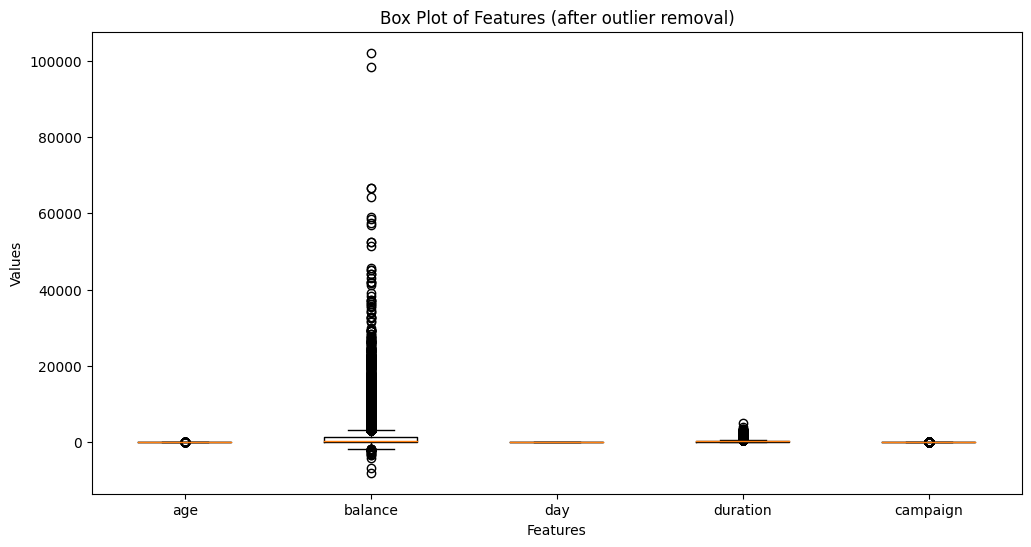

,age,balance,day,duration,campaign
age,1.000000,0.081517,-0.011689,-0.036270,0.016204
balance,0.081517,1.000000,0.011662,0.014072,-0.008137
day,-0.011689,0.011662,1.000000,-0.032983,0.165429
duration,-0.036270,0.014072,-0.032983,1.000000,-0.088387
campaign,0.016204,-0.008137,0.165429,-0.088387,1.000000


In [5]:
# Identify outliers using the IQR method
numeric_features = dataset.select_dtypes(include='number').columns
outliers = pd.DataFrame(False, index=dataset.index, columns=numeric_features)
for feature in numeric_features:
    Q1 = dataset[feature].quantile(0.25)
    Q3 = dataset[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[feature] = ((dataset[feature] < lower_bound) | (dataset[feature] > upper_bound))

# Count the number of outliers
num_outliers = outliers.sum().sum()
print("Number of outliers:", num_outliers)

# Remove outliers from the dataset
#dataset = dataset[~outliers.any(axis=1)]

# Create box plots for each feature
plt.figure(figsize=(12, 6))
plt.boxplot(dataset[numeric_features].values)
plt.xticks(range(1, len(numeric_features) + 1), numeric_features)
plt.xlabel("Features")
plt.ylabel("Values")
plt.title("Box Plot of Features (after outlier removal)")
plt.show()

# Calculate the correlation matrix
corr_matrix = dataset[numeric_features].corr()

# Highlight correlations above the threshold
corr_styled = corr_matrix.style.applymap(lambda x: 'background-color: yellow' if abs(x) >= 0.85 else '')

# Display the styled correlation matrix
corr_styled

## Converting Features

Both the binary columns and the categorical columns need to be converted to numbers.

- To convert the binary columns, simply map 'no' : 0, and 'yes' : 1. 
- To convert categorical columns, we take every possible result from a categorical column, and create a separate column that is binary.

In [55]:
# Convert the binary columns to numeric values
binary_features = ['y', 'default', 'housing', 'loan']
dataset[binary_features] = dataset[binary_features].replace({'no': 0, 'yes': 1})

# Perform numerical (one-hot) encoding on categorical features
categorical_features = ['job', 'marital', 'education', 'contact', 'month']
dataset = pd.get_dummies(dataset, columns=categorical_features)

# Verify the conversions
print("Updated dataset:")
print(dataset.head(3))

# Check the data types of the columns
print("Data types of the columns:")
print(dataset.dtypes)

Updated dataset:
   y   age  default  balance  housing  loan  day  duration  campaign  \
0  0  58.0        0   2143.0        1     0  5.0     261.0       1.0   
1  0  44.0        0     29.0        1     0  5.0     151.0       1.0   
2  0  33.0        0      2.0        1     1  5.0      76.0       1.0   

   job_admin  ...  month_aug  month_dec  month_feb  month_jan  month_jul  \
0      False  ...      False      False      False      False      False   
1      False  ...      False      False      False      False      False   
2      False  ...      False      False      False      False      False   

   month_jun  month_mar  month_may  month_nov  month_oct  
0      False      False       True      False      False  
1      False      False       True      False      False  
2      False      False       True      False      False  

[3 rows x 42 columns]
Data types of the columns:
y                        int64
age                    float64
default                  int64
balance   

## Split into Training and Testing

In [56]:
# Redefine the processed data
x = dataset.iloc[:, 1:].values  # Input features
y = dataset.iloc[:, 0].values   # Output variable

# Split the data into training and testing sets
random_state = 137
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)

# Visualize the shapes of the training and testing sets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (32000, 41)
y_train shape: (32000,)
x_test shape: (8000, 41)
y_test shape: (8000,)


## Addressing Class Imbalance

### Upsampling the Minority Class

In [57]:
# Upsample the minority class
x_train_majority = x_train[y_train == 0]
x_train_minority = x_train[y_train == 1]

print("x_maj shape:", x_train_majority.shape)
print("x_min shape:", x_train_minority.shape)

# Upsample the minority class to match the majority class
x_train_minority_upsampled = resample(x_train_minority,
                                      replace=True,
                                      n_samples=3*len(x_train_minority), # x3 the size of the original minority class
                                      random_state=random_state
                                      ) 

#print("x_train_min_upsamp", x_train_minority_upsampled.shape)

# Upsample the minority class labels to match the upsampled minority class size
y_train_minority_upsampled = np.ones(len(x_train_minority_upsampled), dtype=int)

# Combine the upsampled minority class samples with the majority class samples
x_train_upsampled = np.concatenate([x_train_majority, x_train_minority_upsampled])
y_train_upsampled = np.concatenate([np.zeros(len(x_train_majority), dtype=int), y_train_minority_upsampled])

#print("y_train_0 shape:", y_train[y_train == 0].shape)
#print("y_train_1 shape:", y_train[y_train == 1].shape)

#print("x_train_up shape:", x_train_upsampled.shape)
#print("y_train_up shape:", y_train_upsampled.shape)

# Verify the class balance after upsampling
unique, counts = np.unique(y_train_upsampled, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class Counts after Upsampling:", class_counts)

x_maj shape: (29660, 41)
x_min shape: (2340, 41)
Class Counts after Upsampling: {0: 29660, 1: 7020}


### Adjusting Class Weights

In [52]:
# Create the classifier
classifier = LogisticRegression()

# Fit the classifier with adjusted class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
classifier.fit(x_train, y_train, class_weight=class_weights)

# Make predictions on the test set
y_pred = classifier.predict(x_test)

TypeError: compute_class_weight() takes 1 positional argument but 3 were given

# Model Development

## Initial Run

We can see below that the initial models are able to accurately predict the majority 0 class, but do not perform as well with the minority 1 class. This will be addressed with the Upsampling and Class Weight techniques developed earlier.

As a metric, we will look closely at the **F1 Score**, which is a more balanced measure that considers both precision and recall. Its is useful when there is an imbalance between the classes in the dataset, as in this case.

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


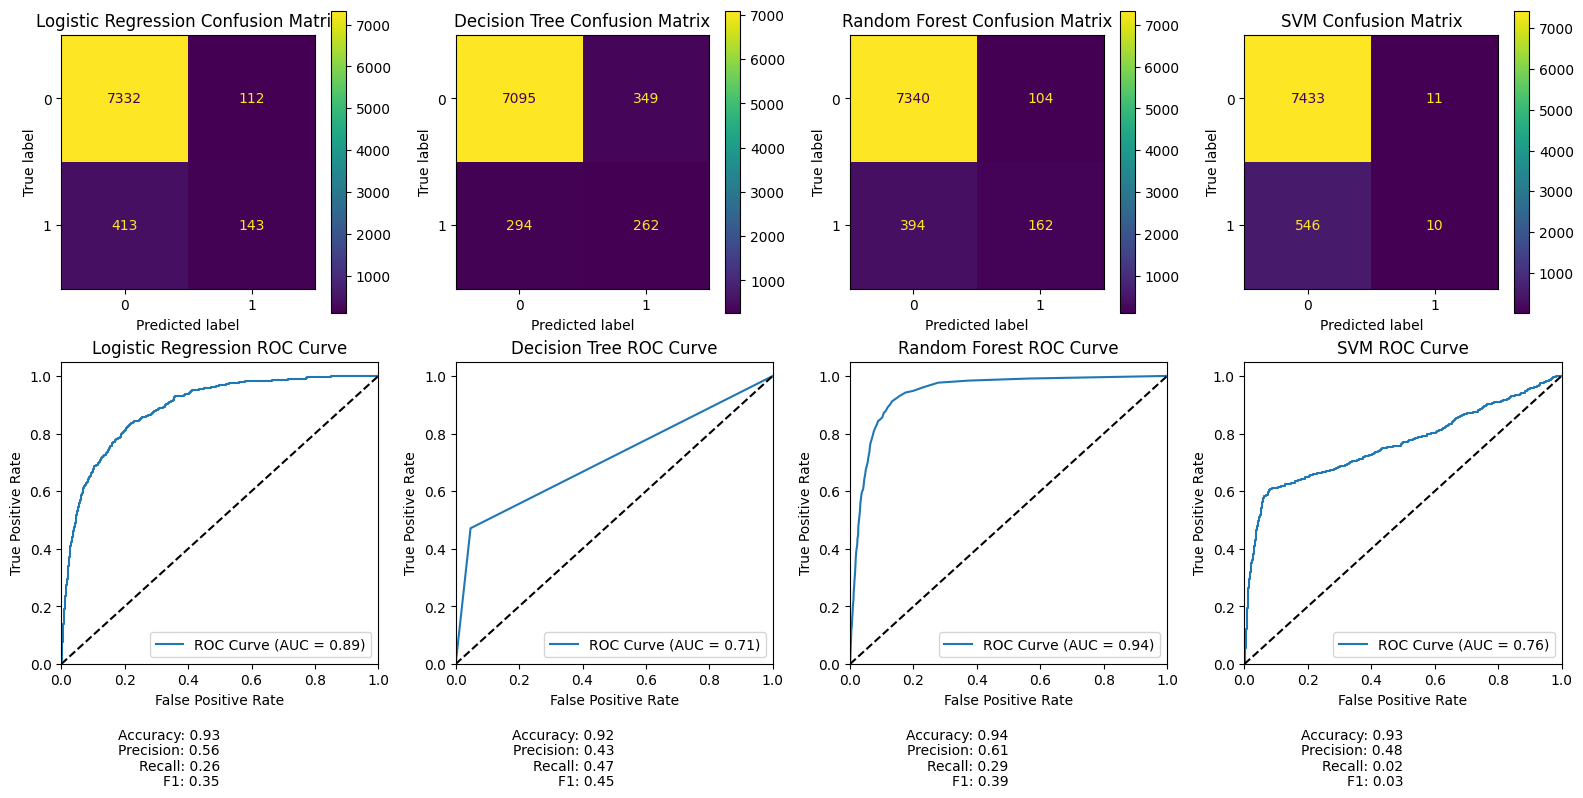

In [58]:
# Initialize the models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True)
]

# Define the model names for labeling
model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

## Upsampled

We can see below that the results using upsampled datasets have uniformly higher **F1 Scores** in comparison with the initial models.

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


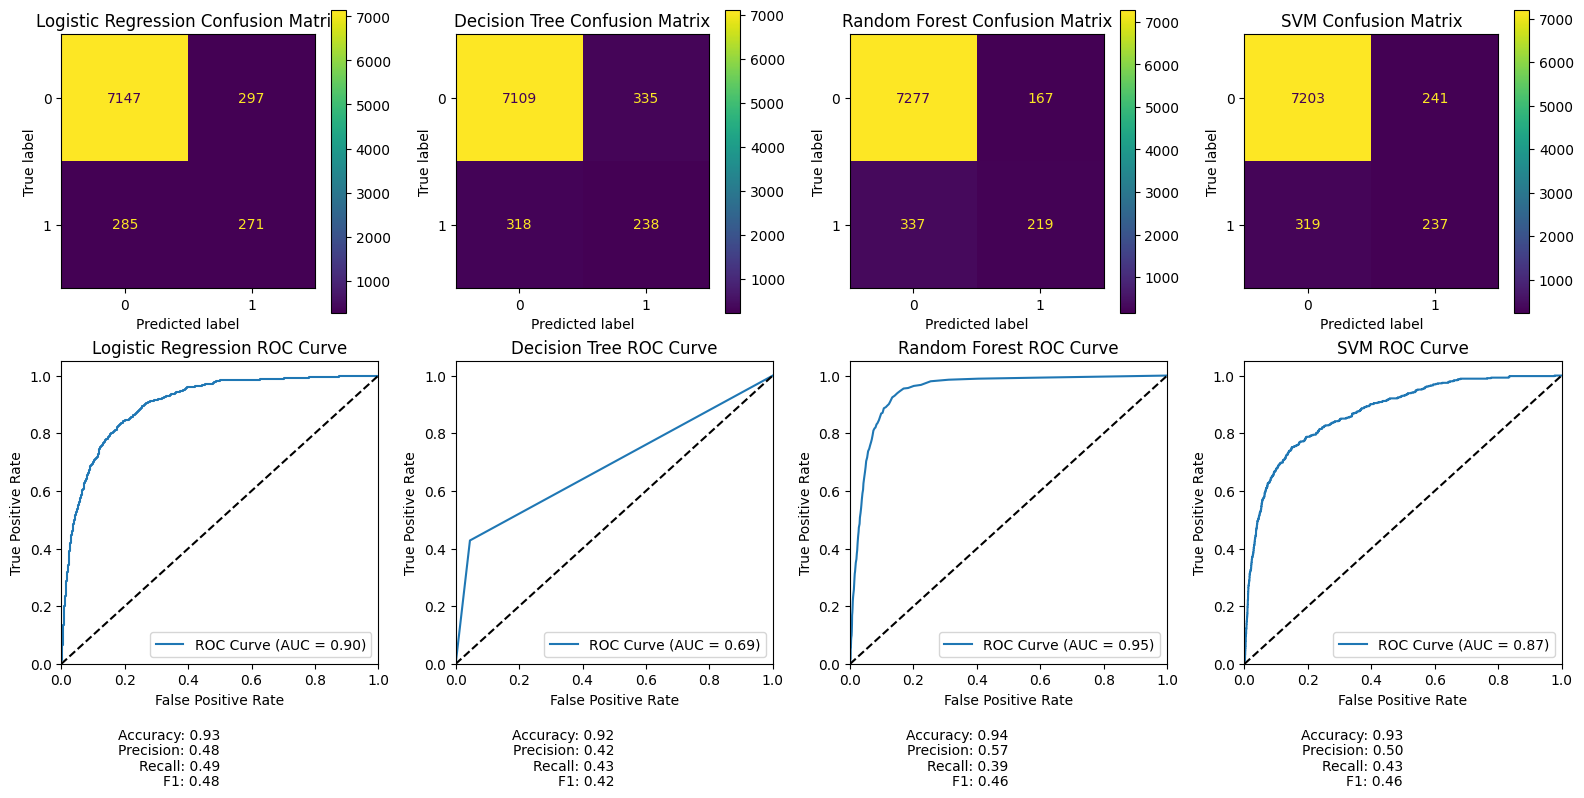

In [59]:
# Initialize the models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True)
]

# Define the model names for labeling
model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM'
]

runModels(models, model_names, x_train_upsampled, x_test, y_train_upsampled, y_test)